# Treasury Yield Analaysis Around FOMC dates

Examining Yields based on Yield Changes around FOMC Dates

*The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates* Whitepaper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4764451)

In [1]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FOMCDrift\root\src")
from EventDrivenSignalGenerator import EventDrivenSignalGenerator

In [3]:
df_yield = EventDrivenSignalGenerator().get_tsy_yields()
df_yield_window = EventDrivenSignalGenerator().get_ordered_window(df_yield, before = -1, after = 1)

In [4]:
def _get_min_date(df: pd.DataFrame) -> pd.DataFrame: return(df.query("date == date.min()"))

def get_hypothetical_yields(df_yield_window: pd.DataFrame) -> pd.DataFrame: 

    df_start = (df_yield_window.drop(
        columns = ["val_diff", "day", "event"]).
        groupby("variable").
        apply(_get_min_date).
        reset_index(drop = True).
        drop(columns = ["date"]).
        rename(columns = {"value": "yld"}))

    df_cumsum = (df_yield_window.drop(
        columns = ["value", "event", "day"]).
        pivot(index = "date", columns = "variable", values = "val_diff").
        cumsum().
        reset_index().
        melt(id_vars = "date").
        merge(right = df_start, how = "inner", on = ["variable"]).
        assign(hypothetical_yield = lambda x: x.yld + x.value).
        drop(columns = ["value", "yld"]))
    
    return df_cumsum

df_hypothetical = get_hypothetical_yields(df_yield_window)

In [5]:
def get_post_hypothetical_yield(df_yield_window: pd.DataFrame) -> pd.DataFrame: 
    
    df_start = (df_yield_window.drop(
        columns = ["val_diff", "day", "event"]).
        groupby("variable").
        apply(_get_min_date).
        reset_index(drop = True).
        drop(columns = ["date"]).
        rename(columns = {"value": "yld"}))

    df_out = (df_yield_window.query(
        "day != -1")
        [["date", "variable", "val_diff"]].
        pivot(index = "date", columns = "variable", values = "val_diff").
        cumsum().
        reset_index().
        melt(id_vars = "date").
        merge(right = df_start, how = "inner", on = ["variable"]).
        assign(hypothetical_yield = lambda x: x.value + x.yld).
        drop(columns = ["value", "yld"]))
    
    return df_out

df_post_hypothetical = get_post_hypothetical_yield(df_yield_window)

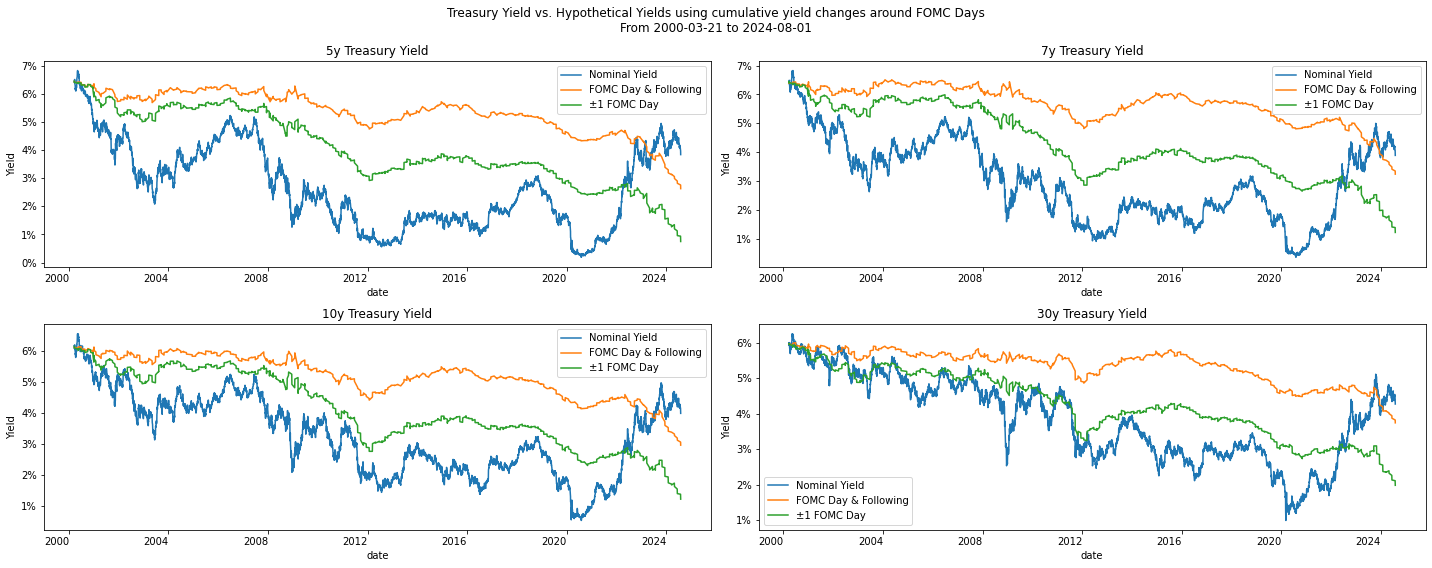

In [6]:
def plot_hypothetical_yield(df_post_hypothetical: pd.DataFrame, df_hypothetical: pd.DataFrame, df_yield: pd.DataFrame) -> plt.Figure:    

    renamer = {
        "DGS5": "5y",
        "DGS7": "7y",
        "DGS10": "10y",
        "DGS30": "30y"}

    fig, axes = plt.subplots(
        ncols   = len(renamer.keys()) // 2, 
        nrows   = len(renamer.keys()) // 2, 
        figsize = (20,8))

    for var, ax in zip(renamer.keys(), axes.flatten()):

        df_post = (df_post_hypothetical.query(
            "variable == @var").
            drop(columns = ["variable"]).
            rename(columns = {"hypothetical_yield": "FOMC Day & Following"}).
            set_index("date"))

        df_full = (df_hypothetical.query(
            "variable == @var").
            drop(columns = ["variable"]).
            rename(columns = {"hypothetical_yield": "±1 FOMC Day"}).
            set_index("date"))

        start_date, end_date = df_full.index.min(), df_full.index.max()

        df_tsy = (df_yield.query(
            "variable == @var").
            query("@start_date <= date <= @end_date").
            set_index("date")
            [["value"]].
            rename(columns = {"value": "Nominal Yield"}))

        df_tsy.plot(ax = ax)
        df_post.plot(ax = ax)
        df_full.plot(ax = ax)

        ax.set_title(renamer[var] + " Treasury Yield")
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/100:.0%}'))
        ax.set_ylabel("Yield")

    fig.suptitle("Treasury Yield vs. Hypothetical Yields using cumulative yield changes around FOMC Days\nFrom {} to {}".format(
        df_post_hypothetical.date.min(),
        df_post_hypothetical.date.max()))
    plt.tight_layout()
    
plot_hypothetical_yield(df_post_hypothetical, df_hypothetical, df_yield)

In [7]:
def _cumulate(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(cum_yield = lambda x: x.val_diff.cumsum()))

def _get_first_tsy(df: pd.DataFrame) -> pd.DataFrame: return(df.query("date == date.min()"))

def get_cumulative_day_changes(df_yield_window: pd.DataFrame) -> pd.DataFrame:

    df_cum_day = (df_yield_window.drop(
        columns = ["value", "event"]).
        groupby(["variable", "day"]).
        apply(_cumulate).
        reset_index(drop = True))
    
    df_start = (df_yield_window[
        ["date", "variable", "day", "value"]].
        groupby(["variable", "day"]).
        apply(_get_first_tsy).
        reset_index(drop = True).
        drop(columns = ["date"]).
        rename(columns = {"value": "start"}).
        merge(right = df_cum_day, how = "inner", on = ["variable", "day"]).
        assign(hypothetical_yield = lambda x: x.start + x.cum_yield).
        drop(columns = ["val_diff", "cum_yield"]))
    
    return df_start

df_cum_day = get_cumulative_day_changes(df_yield_window)

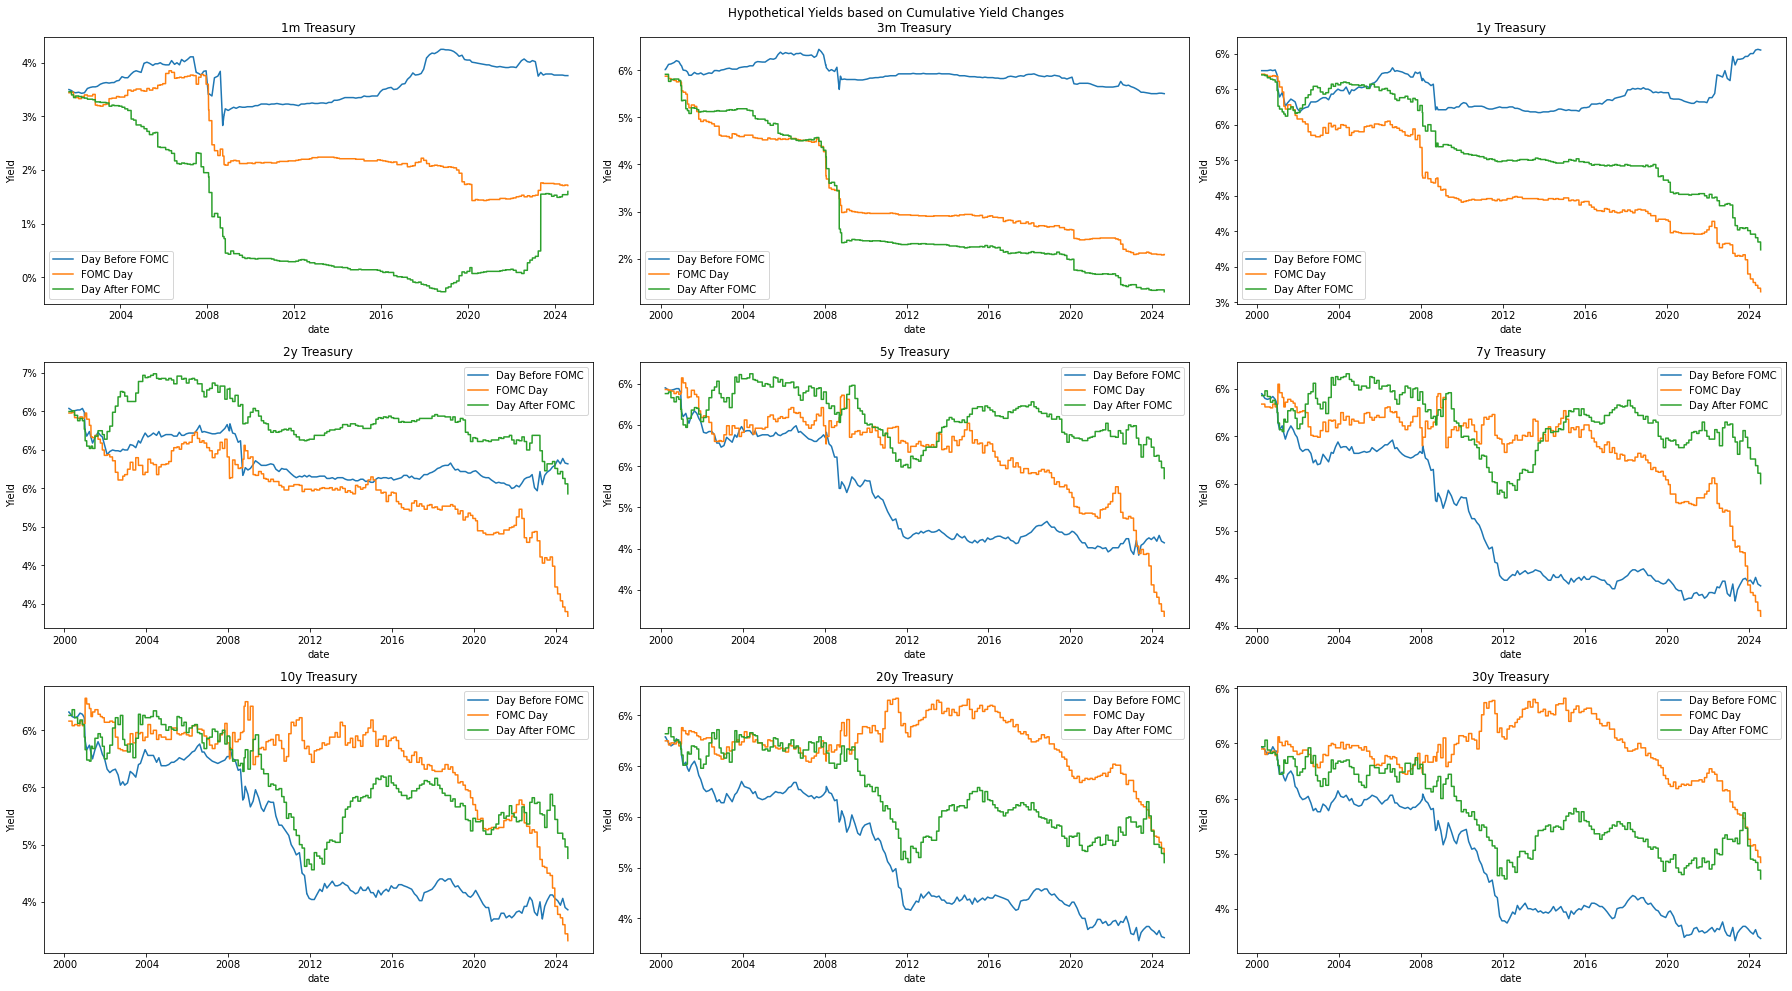

In [8]:
def plot_spef_day_changes(df_cum_day: pd.DataFrame) -> plt.Figure: 
    
    renamer = {
        -1: "Day Before FOMC",
        0 : "FOMC Day",
        1 : "Day After FOMC"}

    variables = {
        "DGS1MO": "1m",
        "DGS3MO": "3m",
        "DGS1"  : "1y",
        "DGS2"  : "2y",
        "DGS5"  : "5y",
        "DGS7"  : "7y",
        "DGS10" : "10y",
        "DGS20" : "20y",
        "DGS30" : "30y"}

    fig, axes = plt.subplots(
        ncols   = len(variables.keys()) // 3,
        nrows   = len(variables.keys()) // 3,
        figsize = (25,14))

    for variable, ax in zip(variables.keys(), axes.flatten()):

        (df_cum_day.query(
            "variable == @variable")
            [["date", "day", "hypothetical_yield"]].
            rename(columns = {"day": ""}).
            pivot(index = "date", columns = "", values = "hypothetical_yield").
            fillna(method = "ffill").
            rename(columns = renamer).
            plot(
                title  = variables[variable] + " Treasury",
                ax     = ax,
                ylabel = "Yield"))

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/100:.0%}'))

    fig.suptitle("Hypothetical Yields based on Cumulative Yield Changes")
    plt.tight_layout()
    
plot_spef_day_changes(df_cum_day)